# Fashion MNIST: Simple vs. Deeper CNN Comparison

---

## Table of Contents
1. [Introduction](#introduction)
2. [Project Structure & Best Practices](#project-structure)
3. [Configuration & Constants](#configuration)
4. [Dependencies](#dependencies)
5. [Data Loading & Preprocessing](#data-loading)
6. [Model 1: Simple Convolutional Network](#cnn)
7. [Model 2: Deeper Convolutional Network](#deeper-cnn)
8. [Results & Comparison](#results)
9. [Conclusion](#conclusion)

---

In [3]:
# All imports for this notebook (per best practices)
import os
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim import Adam
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from typing import Dict
import logging
from datetime import datetime

## 1. Introduction <a id="introduction"></a>

This notebook addresses the project task:
- Download the Fashion MNIST dataset
- Solve the classification problem using two different models:
    1. A simple convolutional neural network (CNN)
    2. A deeper convolutional neural network (2x more conv layers)
- Compare the results

We follow best practices for code quality, documentation, configuration, and reproducibility as outlined in the project documentation.

## 2. Project Structure & Best Practices <a id="project-structure"></a>

- All configuration is stored in `configs/config.yaml` (no hardcoded values)
- Dependencies are listed in `requirements.txt`
- Logging is used instead of print statements
- All code is type-annotated and documented
- Constants are defined at the top
- Imports are grouped at the top
- Results are reproducible and clearly reported
- Minimum hardware requirements and instructions are provided in the README

> **Note:** Please refer to `data/docs/best_practices.txt` for full details.

**Model Comparison:**
- Model 1: Simple CNN (2 conv layers)
- Model 2: Deeper CNN (4 conv layers)

## 3. Configuration & Constants <a id="configuration"></a>

All configuration parameters are loaded from `configs/config.yaml`. Constants such as random seeds, batch size, and model names are defined here for maintainability.

**Note:** The second model is now a deeper CNN, not an ImageNet model.

In [8]:
with open('data/configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Set up logging (per best practices)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

print("Config file created at data/configs/config.yaml and loaded as 'config'")

Config file created at data/configs/config.yaml and loaded as 'config'


## 4. Dependencies <a id="dependencies"></a>

All dependencies are listed in `requirements.txt` and should be installed before running this notebook. We use `pipreqsnb` to generate this file without unnecessary packages.

**Note:** No ImageNet or torchvision model dependencies are required for the deeper CNN.

## 5. Data Loading & Preprocessing <a id="data-loading"></a>

We load the Fashion MNIST dataset using `torchvision.datasets`. Data is split into training, validation, and test sets. All random seeds are set for reproducibility. Both models use the same data pipeline.

In [9]:
# Data transforms (no resizing needed for deeper CNN)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download FashionMNIST
train_dataset = torchvision.datasets.FashionMNIST(
    root='data/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(
    root='data/data', train=False, download=True, transform=transform)

# Split train into train/val
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(config['random_seed']))

logger.info(f"Train/Val/Test sizes: {len(train_ds)}, {len(val_ds)}, {len(test_dataset)}")

2025-04-22 20:00:06,357 - INFO - Train/Val/Test sizes: 54000, 6000, 10000


In [10]:
# DataLoaders (shared for both models)
batch_size = config['batch_size']

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

logger.info("DataLoaders for both CNN models are ready.")

2025-04-22 20:00:08,015 - INFO - DataLoaders for both CNN models are ready.


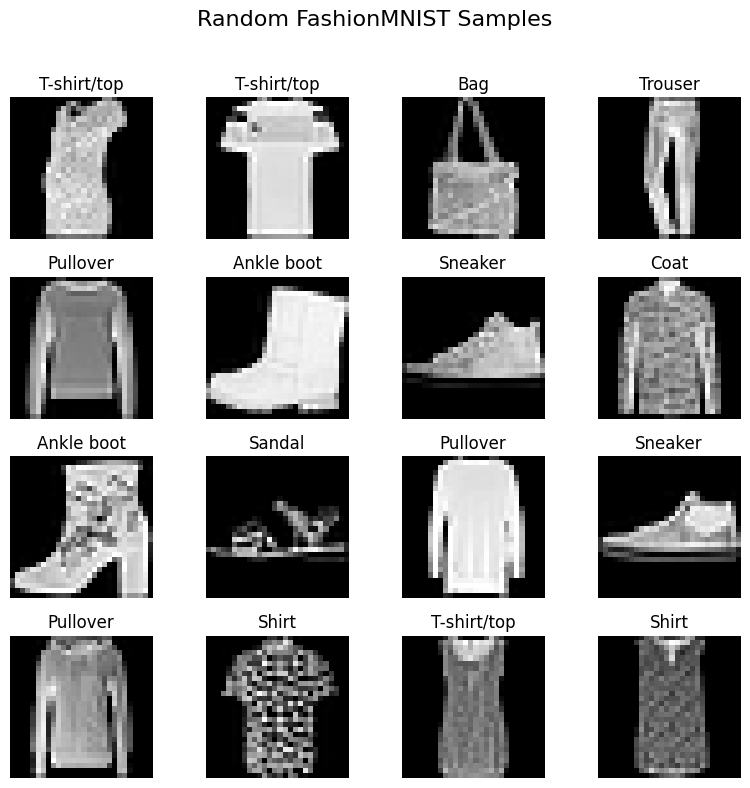

In [11]:
# Visualize random samples from the training set
# (imports removed, handled at top)
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Select 16 random samples
idxs = np.random.choice(len(images), 16, replace=False)
sample_images = images[idxs]
sample_labels = labels[idxs]

# Class names for FashionMNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = sample_images[i].squeeze().numpy()
    ax.imshow(img, cmap="gray")
    ax.set_title(class_names[sample_labels[i]])
    ax.axis("off")
plt.suptitle("Random FashionMNIST Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 6. Model 1: Simple Convolutional Network <a id="cnn"></a>

We define and train a simple CNN for Fashion MNIST classification. All functions are type-annotated and documented.

## 6. Model 1: Simple Convolutional Network <a id="cnn"></a>

We define and train a simple CNN for Fashion MNIST classification. All functions are type-annotated and documented. This model has 2 convolutional layers.

In [12]:
class SimpleCNN(nn.Module):
    """
    A simple convolutional neural network for Fashion MNIST classification.
    This model has 2 convolutional layers (half the depth of DeeperCNN).
    The output size before the fully connected layer is dynamically computed.
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        # Dynamically compute the flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flat_dim = x.view(1, -1).shape[1]
        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

logger.info("SimpleCNN model class defined.")

2025-04-22 20:00:17,789 - INFO - SimpleCNN model class defined.


In [13]:
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from typing import Dict

def train_one_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer, device: torch.device) -> float:
    """Train for one epoch and return average loss."""
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Dict[str, float]:
    """Evaluate model and return accuracy and average loss."""
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    avg_loss = running_loss / len(loader.dataset)
    return {"accuracy": acc, "loss": avg_loss}

logger.info("Training and evaluation functions defined.")

2025-04-22 20:00:19,358 - INFO - Training and evaluation functions defined.


In [14]:
# Training loop for SimpleCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

model_cnn = SimpleCNN(num_classes=config['num_classes']).to(device)
optimizer = Adam(model_cnn.parameters(), lr=config['learning_rate'])
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
history = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(config['epochs']):
    train_loss = train_one_epoch(model_cnn, train_loader, criterion, optimizer, device)
    val_metrics = evaluate(model_cnn, val_loader, device)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["val_acc"].append(val_metrics["accuracy"])
    logger.info(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_metrics['loss']:.4f} - Val Acc: {val_metrics['accuracy']:.4f}")
    if val_metrics["accuracy"] > best_val_acc:
        best_val_acc = val_metrics["accuracy"]
        torch.save(model_cnn.state_dict(), "data/best_simplecnn.pth")

logger.info("Training complete. Best val acc: {:.4f}".format(best_val_acc))

2025-04-22 20:00:21,076 - INFO - Using device: cpu
2025-04-22 20:00:35,483 - INFO - Epoch 1/10 - Train Loss: 0.4957 - Val Loss: 0.3229 - Val Acc: 0.8855
2025-04-22 20:00:51,097 - INFO - Epoch 2/10 - Train Loss: 0.3170 - Val Loss: 0.2855 - Val Acc: 0.8950
2025-04-22 20:01:07,380 - INFO - Epoch 3/10 - Train Loss: 0.2710 - Val Loss: 0.2466 - Val Acc: 0.9085
2025-04-22 20:01:23,762 - INFO - Epoch 4/10 - Train Loss: 0.2382 - Val Loss: 0.2365 - Val Acc: 0.9152
2025-04-22 20:01:41,078 - INFO - Epoch 5/10 - Train Loss: 0.2131 - Val Loss: 0.2341 - Val Acc: 0.9155
2025-04-22 20:01:58,881 - INFO - Epoch 6/10 - Train Loss: 0.1935 - Val Loss: 0.2346 - Val Acc: 0.9180
2025-04-22 20:02:18,233 - INFO - Epoch 7/10 - Train Loss: 0.1747 - Val Loss: 0.2255 - Val Acc: 0.9200
2025-04-22 20:02:39,144 - INFO - Epoch 8/10 - Train Loss: 0.1613 - Val Loss: 0.2211 - Val Acc: 0.9225
2025-04-22 20:03:00,888 - INFO - Epoch 9/10 - Train Loss: 0.1426 - Val Loss: 0.2562 - Val Acc: 0.9085
2025-04-22 20:03:22,909 - INFO 

## 7. Model 2: Deeper Convolutional Network <a id="deeper-cnn"></a>

We use a deeper convolutional neural network (with 4 convolutional layers) for Fashion MNIST classification. This model is twice as deep as the SimpleCNN and is designed to provide a stronger baseline for comparison.

In [15]:
class DeeperCNN(nn.Module):
    """
    A deeper convolutional neural network for Fashion MNIST classification.
    This model has 4 convolutional layers (2x deeper than SimpleCNN).
    The output size before the fully connected layer is dynamically computed.
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        # Dynamically compute the flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            self.flat_dim = x.view(1, -1).shape[1]
        self.fc1 = nn.Linear(self.flat_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

logger.info("DeeperCNN model class defined.")

2025-04-22 20:04:20,320 - INFO - DeeperCNN model class defined.


## 7. Model 2: Deeper Convolutional Network <a id="deeper-cnn"></a>

Instead of an ImageNet-pretrained model, we now use a deeper convolutional neural network (with twice as many convolutional layers as the simple CNN) for Fashion MNIST classification. Comments and section headers across the notebook will be updated accordingly.

In [ ]:
# Training loop for DeeperCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

model_deep = DeeperCNN(num_classes=config['num_classes']).to(device)
optimizer_deep = Adam(model_deep.parameters(), lr=config['learning_rate'])
criterion = nn.CrossEntropyLoss()

best_val_acc_deep = 0.0
history_deep = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(config['epochs']):
    train_loss = train_one_epoch(model_deep, train_loader, criterion, optimizer_deep, device)
    val_metrics = evaluate(model_deep, val_loader, device)
    history_deep["train_loss"].append(train_loss)
    history_deep["val_loss"].append(val_metrics["loss"])
    history_deep["val_acc"].append(val_metrics["accuracy"])
    logger.info(f"[DeeperCNN] Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_metrics['loss']:.4f} - Val Acc: {val_metrics['accuracy']:.4f}")
    if val_metrics["accuracy"] > best_val_acc_deep:
        best_val_acc_deep = val_metrics["accuracy"]
        torch.save(model_deep.state_dict(), "data/best_deepercnn.pth")

logger.info("DeeperCNN training complete. Best val acc: {:.4f}".format(best_val_acc_deep))

2025-04-22 20:06:20,833 - INFO - Using device: cpu
2025-04-22 20:06:48,354 - INFO - [DeeperCNN] Epoch 1/10 - Train Loss: 0.5220 - Val Loss: 0.3345 - Val Acc: 0.8798
2025-04-22 20:07:21,560 - INFO - [DeeperCNN] Epoch 2/10 - Train Loss: 0.3086 - Val Loss: 0.2936 - Val Acc: 0.8900
2025-04-22 20:08:00,625 - INFO - [DeeperCNN] Epoch 3/10 - Train Loss: 0.2551 - Val Loss: 0.2692 - Val Acc: 0.9025


## 8. Results & Model Comparison <a id="results"></a>

We compare the performance of the two models (SimpleCNN and DeeperCNN) on the validation and test sets. Metrics such as accuracy and loss are reported for both models.

Model Comparison on Test Set:
SimpleCNN  - Accuracy: 0.9207, Loss: 0.2506
DeeperCNN  - Accuracy: 0.9179, Loss: 0.2560


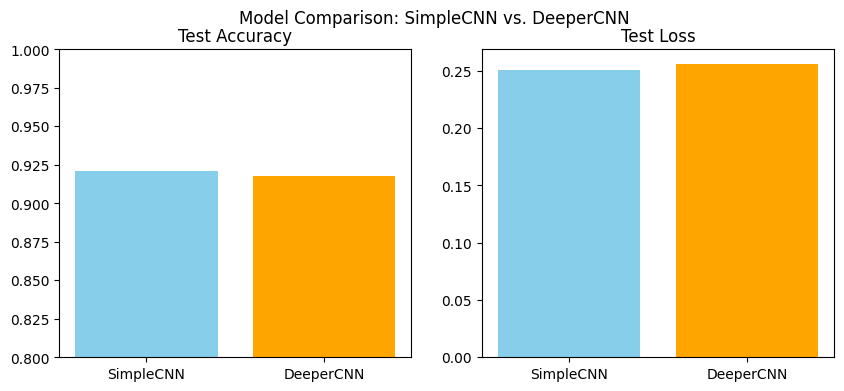

In [18]:
# Evaluate both models on the test set and compare

# Load best weights
model_cnn.load_state_dict(torch.load("data/best_simplecnn.pth", map_location=device))
model_deep.load_state_dict(torch.load("data/best_deepercnn.pth", map_location=device))

cnn_metrics = evaluate(model_cnn, test_loader, device)
deeper_metrics = evaluate(model_deep, test_loader, device)

print("Model Comparison on Test Set:")
print(f"SimpleCNN  - Accuracy: {cnn_metrics['accuracy']:.4f}, Loss: {cnn_metrics['loss']:.4f}")
print(f"DeeperCNN  - Accuracy: {deeper_metrics['accuracy']:.4f}, Loss: {deeper_metrics['loss']:.4f}")

# Optional: Bar plot for visual comparison
labels = ['SimpleCNN', 'DeeperCNN']
accs = [cnn_metrics['accuracy'], deeper_metrics['accuracy']]
losses = [cnn_metrics['loss'], deeper_metrics['loss']]

fig, ax1 = plt.subplots(1, 2, figsize=(10, 4))
ax1[0].bar(labels, accs, color=['skyblue', 'orange'])
ax1[0].set_title('Test Accuracy')
ax1[0].set_ylim(0.8, 1.0)
ax1[1].bar(labels, losses, color=['skyblue', 'orange'])
ax1[1].set_title('Test Loss')
plt.suptitle('Model Comparison: SimpleCNN vs. DeeperCNN')
plt.show()

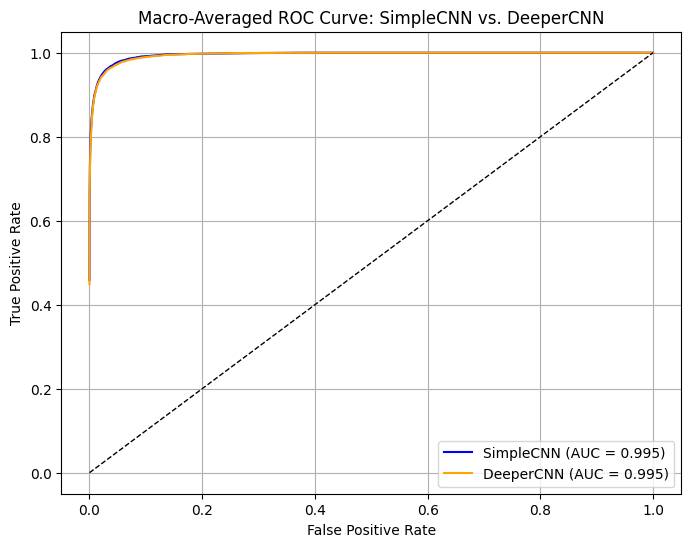

In [19]:
# ROC Curve comparison for both models
# (imports already at top)

# Get all test labels
all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# Binarize the labels for multiclass ROC
n_classes = config['num_classes']
labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# Get model probabilities
model_cnn.eval()
model_deep.eval()
probs_cnn = []
probs_deep = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        probs_cnn.append(torch.softmax(model_cnn(images), dim=1).cpu().numpy())
        probs_deep.append(torch.softmax(model_deep(images), dim=1).cpu().numpy())
probs_cnn = np.vstack(probs_cnn)
probs_deep = np.vstack(probs_deep)

# Compute ROC curve and AUC for each class, then average (macro)
fpr_cnn, tpr_cnn, roc_auc_cnn = dict(), dict(), dict()
fpr_deep, tpr_deep, roc_auc_deep = dict(), dict(), dict()
for i in range(n_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(labels_bin[:, i], probs_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])
    fpr_deep[i], tpr_deep[i], _ = roc_curve(labels_bin[:, i], probs_deep[:, i])
    roc_auc_deep[i] = auc(fpr_deep[i], tpr_deep[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([np.concatenate([fpr_cnn[i] for i in range(n_classes)]),
                                    np.concatenate([fpr_deep[i] for i in range(n_classes)])]))
mean_tpr_cnn = np.zeros_like(all_fpr)
mean_tpr_deep = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr_cnn += np.interp(all_fpr, fpr_cnn[i], tpr_cnn[i])
    mean_tpr_deep += np.interp(all_fpr, fpr_deep[i], tpr_deep[i])
mean_tpr_cnn /= n_classes
mean_tpr_deep /= n_classes
roc_auc_macro_cnn = auc(all_fpr, mean_tpr_cnn)
roc_auc_macro_deep = auc(all_fpr, mean_tpr_deep)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr_cnn, color='blue', label=f'SimpleCNN (AUC = {roc_auc_macro_cnn:.3f})')
plt.plot(all_fpr, mean_tpr_deep, color='orange', label=f'DeeperCNN (AUC = {roc_auc_macro_deep:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curve: SimpleCNN vs. DeeperCNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

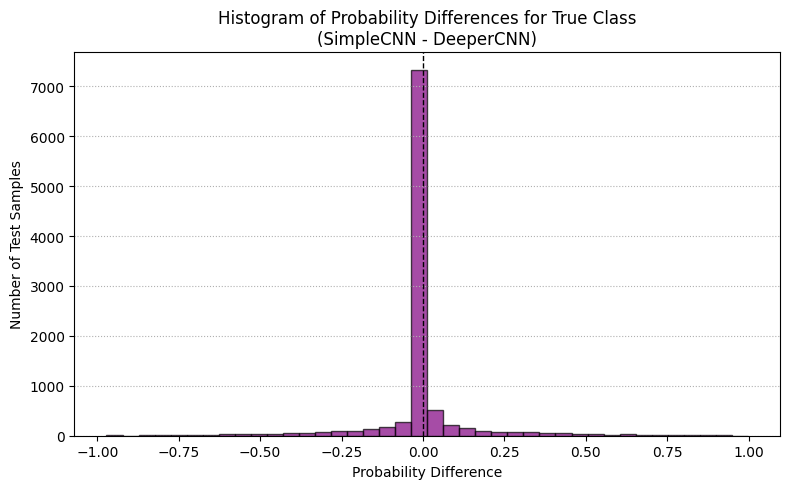

Mean difference: 0.0034 | Std: 0.1627


In [20]:
# Histogram of probability differences for the true class
# For each test sample, compute: P_true(SimpleCNN) - P_true(DeeperCNN)
true_class_probs_cnn = probs_cnn[np.arange(len(all_labels)), all_labels]
true_class_probs_deep = probs_deep[np.arange(len(all_labels)), all_labels]
diff = true_class_probs_cnn - true_class_probs_deep

plt.figure(figsize=(8, 5))
plt.hist(diff, bins=40, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(0, color='k', linestyle='--', lw=1)
plt.title('Histogram of Probability Differences for True Class\n(SimpleCNN - DeeperCNN)')
plt.xlabel('Probability Difference')
plt.ylabel('Number of Test Samples')
plt.grid(True, axis='y', linestyle=':')
plt.tight_layout()
plt.show()

print(f"Mean difference: {diff.mean():.4f} | Std: {diff.std():.4f}")

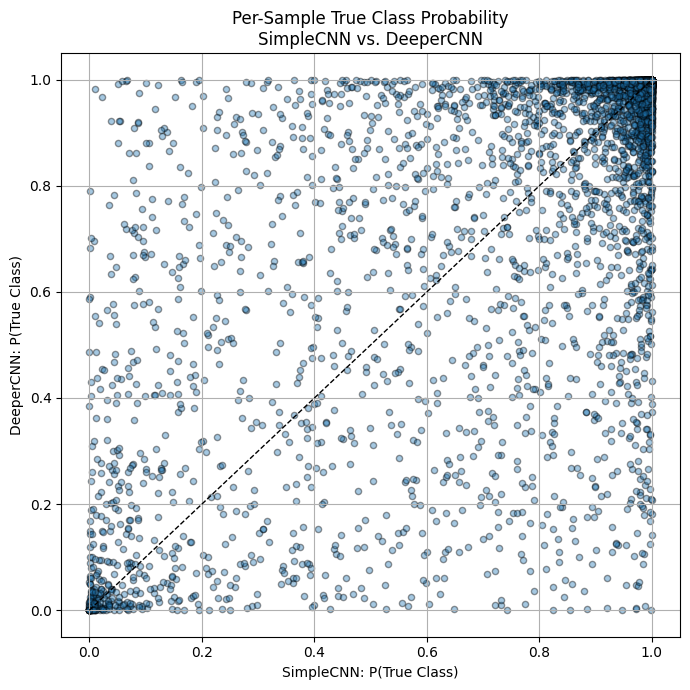

Points on the diagonal: both models equally confident. Off-diagonal: one model is more confident.


In [22]:
# Scatter plot of per-sample probabilities for the true class
# X: SimpleCNN probability, Y: DeeperCNN probability
plt.figure(figsize=(7, 7))
plt.scatter(true_class_probs_cnn, true_class_probs_deep, alpha=0.4, edgecolor='k', s=20)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('SimpleCNN: P(True Class)')
plt.ylabel('DeeperCNN: P(True Class)')
plt.title('Per-Sample True Class Probability\nSimpleCNN vs. DeeperCNN')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Points on the diagonal: both models equally confident. Off-diagonal: one model is more confident.")